In [29]:
import re
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import warnings
import scipy.stats
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from time import sleep
import sys

warnings.filterwarnings('ignore')

Load and Process Dataset

To-do:
- Average columns in spreadsheet to form a cohesive valence and arousal score
- Read in new columns

In [24]:
headers = ['Anonymized Message', 'Valence1', 'Valence2', 'Arousal1', 'Arousal2']
dtypes = {'Anonymized Message':'str', 'Valence1':'float', 'Valence2':'float', 'Arousal1':'float', 'Arousal2':'float'}
data = pd.read_csv("dataset-fb-valence-arousal-anon.csv", encoding='utf8', skiprows=[0], names=headers, dtype=dtypes, na_filter=False)
data = data.sample(frac=1).reset_index(drop=True)

Pre-processing

In [25]:
# set all words to lowercase and remove anything that isn't a letter or space
data['Anonymized Message'].apply(lambda x: x.lower()) #transform text to lowercase
data['Anonymized Message'] = data['Anonymized Message'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))

# find and remove all stop words
stop = stopwords.words('english')
data['Anonymized Message'] = data['Anonymized Message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

Creating Model(s)

To-Do
- Define and train model for arousal
- Redefine valence model once valence columns are merged for input

In [32]:
def get_model(col):
    # setup a tokenizer to keep the most frequent 5000 words
    tokenizer = Tokenizer(num_words=5000, split=" ")
    tokenizer.fit_on_texts(data['Anonymized Message'].values)
    
    # define input X
    X = tokenizer.texts_to_sequences(data['Anonymized Message'].values)
    X = pad_sequences(X) # padding our text vector so they all have the same length
    
    # define expected output for training and testing
    y = pd.get_dummies(data[col]).values
    
    # setup and establish model with 9 outputs
    # output will be an array of length 9. 
    # the highest output value corresponds to the model's guess
    model = Sequential()
    model.add(Embedding(5000, 64, input_length=X.shape[1]))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
    model.add(LSTM(264, dropout=0.3, recurrent_dropout=0.2))
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    y = pd.get_dummies(data[col]).values
    
    # split X, y into training and testing 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    return model, X_train, X_test, y_train, y_test

v1_model, v1_xtrain, v1_xtest, v1_ytrain, v1_ytest = get_model('Valence1')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 148, 64)           320000    
                                                                 
 dropout_2 (Dropout)         (None, 148, 64)           0         
                                                                 
 lstm_4 (LSTM)               (None, 148, 64)           33024     
                                                                 
 lstm_5 (LSTM)               (None, 264)               347424    
                                                                 
 dense_2 (Dense)             (None, 9)                 2385      
                                                                 
Total params: 702,833
Trainable params: 702,833
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
__________________________

Training Model(s)

To-Do:
- Train new valence and arousal models (takes about 5ish minutes per model)
- Consider if more epochs would be useful. Training would take longer but might yield better results

In [33]:
def train_model(model, X, y):
    batch_size = 32
    epochs = 8
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=2)
    return model

v1_model.summary()
v1_model = train_model(v1_model, v1_xtrain, v1_ytrain)
v1_model.save('valence1_analysis.h5')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 148, 64)           320000    
                                                                 
 dropout_3 (Dropout)         (None, 148, 64)           0         
                                                                 
 lstm_6 (LSTM)               (None, 148, 64)           33024     
                                                                 
 lstm_7 (LSTM)               (None, 264)               347424    
                                                                 
 dense_3 (Dense)             (None, 9)                 2385      
                                                                 
Total params: 702,833
Trainable params: 702,833
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
73/73 - 43s - loss: 1.9530 - accuracy:

Testing Model

To-Do:
- Test new valence and arousal models

Arousal1 model has an accuracy of 26.08%
Arousal1 model has a correlation coefficient of 0.30


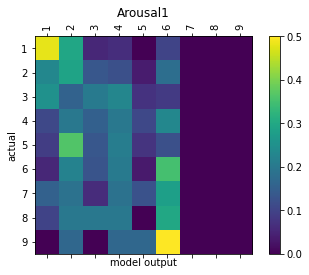

In [34]:
def test_model(col, model, X_test, y_test):
    # make predictions
    predictions = model.predict(X_test)
    
    # establish confusion matrix
    confusion = np.zeros([9,9])
    correct = 0
    total = 0
    pred_vals = []
    actual_vals = []
    for i, prediction in enumerate(predictions):
        total += 1
        guess_i = np.argmax(prediction)
        actual_i = np.argmax(y_test[i])
        confusion[actual_i][guess_i] += 1
        if guess_i == actual_i:
            correct += 1
        pred_vals.append(guess_i + 1)
        actual_vals.append(actual_i + 1)
    
    # Correlation coefficient is used as a metric in the original paper
    # Our values seem to be lower than the values generated in the paper itself;
    # however, it seems that our valence r-val is generally comparable to the other
    # methods listed in table 4 of the original paper.
    r_val = scipy.stats.pearsonr(pred_vals, actual_vals)[0]
    acc = correct/total * 100
    
    print('%s model has an accuracy of %.2f%%' % (col, acc))
    print('%s model has a correlation coefficient of %.2f' % (col, r_val))
    
    # normalize confusion matrix
    for i in range(0, 9):
        sum = confusion[i].sum()
        if sum > 0:
            confusion[i] = confusion[i] / sum

    # plot results
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion)
    fig.colorbar(cax)
    
    categories = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    ax.set_xticklabels([''] + categories, rotation=90)
    ax.set_yticklabels([''] + categories)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.xlabel('model output')
    plt.ylabel('actual')
    plt.title(col)
    
    plt.show()
    
# make and plot predictions
test_model('Valence1', v1_model, v1_xtest, v1_ytest)